# 天气数据 ERA5 分析 Notebook

本notebook提供了完整的ERA5天气数据分析工具，包括：
- 数据加载和基本信息查看
- 统计分析
- 空间分布可视化
- 时间序列分析
- 季节性分析
- 变量相关性分析


## 1. 导入库和环境设置


In [1]:
# !gcloud auth application-default login

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 设置绘图样式
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ 库导入完成")


/Users/mobvoi/miniconda3/lib/python3.11/site-packages/xarray/backends/scipy_.py:39: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.io import netcdf_file as netcdf_file_base


✓ 库导入完成


## 2. 数据加载


In [3]:
# 数据路径
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
# obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-512x256_equiangular_conservative.zarr'

# 加载数据
print("正在加载数据...")
ds = xr.open_zarr(obs_path)
print("✓ 数据加载完成！")


正在加载数据...
✓ 数据加载完成！


## 3. 数据基本信息


In [4]:
# 显示数据集结构
ds


<xarray.Dataset> Size: 81GB
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * time                                              (time) datetime64[ns] 736kB ...
  * longitude                                         (longitude) float64 512B ...
  * latitude                                          (latitude) float64 256B ...
  * level                                             (level) int64 104B 50 ....
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 754MB ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 754MB ...
    10m_wind_speed                                    (time, longitude, latitude) float32 754MB ...
    2m_temperature                                    (time, longitude, latitude) float32 754MB ...
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 8kB ...
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 8kB ...
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 8kB ...
    type_of_low_vegetation                            (longitude, latitude) float32 8kB ...
    u_component_of_wind                               (time, level, longitude, latitude) float32 10GB ...
    v_component_of_wind                               (time, level, longitude, latitude) float32 10GB ...
    vertical_velocity                                 (time, level, longitude, latitude) float32 10GB ...
    wind_speed                                        (time, level, longitude, latitude) float32 10GB ...

In [5]:
# 数据维度信息
print("数据维度:")
for dim, size in ds.dims.items():
    print(f"  {dim}: {size}")

print("\n可用变量:")
for var in ds.data_vars:
    print(f"  {var}: {ds[var].shape}")


数据维度:
  time: 92044
  longitude: 64
  latitude: 32
  level: 13

可用变量:
  10m_u_component_of_wind: (92044, 64, 32)
  10m_v_component_of_wind: (92044, 64, 32)
  10m_wind_speed: (92044, 64, 32)
  2m_temperature: (92044, 64, 32)
  angle_of_sub_gridscale_orography: (64, 32)
  anisotropy_of_sub_gridscale_orography: (64, 32)
  geopotential: (92044, 13, 64, 32)
  geopotential_at_surface: (64, 32)
  high_vegetation_cover: (64, 32)
  lake_cover: (64, 32)
  lake_depth: (64, 32)
  land_sea_mask: (64, 32)
  low_vegetation_cover: (64, 32)
  mean_sea_level_pressure: (92044, 64, 32)
  sea_ice_cover: (92044, 64, 32)
  sea_surface_temperature: (92044, 64, 32)
  slope_of_sub_gridscale_orography: (64, 32)
  soil_type: (64, 32)
  specific_humidity: (92044, 13, 64, 32)
  standard_deviation_of_filtered_subgrid_orography: (64, 32)
  standard_deviation_of_orography: (64, 32)
  surface_pressure: (92044, 64, 32)
  temperature: (92044, 13, 64, 32)
  toa_incident_solar_radiation: (92044, 64, 32)
  toa_incident_sola

In [6]:
# 时间和空间范围
if 'time' in ds.coords:
    time_vals = pd.to_datetime(ds['time'].values)
    print(f"\n时间范围:")
    print(f"  开始: {time_vals[0]}")
    print(f"  结束: {time_vals[-1]}")
    print(f"  总时间步: {len(time_vals):,}")

if 'latitude' in ds.coords and 'longitude' in ds.coords:
    print(f"\n空间范围:")
    print(f"  纬度: {ds['latitude'].values.min():.2f}° ~ {ds['latitude'].values.max():.2f}°")
    print(f"  经度: {ds['longitude'].values.min():.2f}° ~ {ds['longitude'].values.max():.2f}°")



时间范围:
  开始: 1959-01-01 00:00:00
  结束: 2021-12-31 18:00:00
  总时间步: 92,044

空间范围:
  纬度: -87.19° ~ 87.19°
  经度: 0.00° ~ 354.38°


## 4. 选择分析变量


In [7]:
# 获取所有变量
variables = list(ds.data_vars)
print(f"变量数量: {len(variables)}")
print(f"可用变量: {variables}")

# 选择要分析的变量
# target_var = variables[0]  # 修改索引或直接指定变量名
target_var = '2m_temperature'
print(f"\n当前分析变量: {target_var}")


变量数量: 38
可用变量: ['10m_u_component_of_wind', '10m_v_component_of_wind', '10m_wind_speed', '2m_temperature', 'angle_of_sub_gridscale_orography', 'anisotropy_of_sub_gridscale_orography', 'geopotential', 'geopotential_at_surface', 'high_vegetation_cover', 'lake_cover', 'lake_depth', 'land_sea_mask', 'low_vegetation_cover', 'mean_sea_level_pressure', 'sea_ice_cover', 'sea_surface_temperature', 'slope_of_sub_gridscale_orography', 'soil_type', 'specific_humidity', 'standard_deviation_of_filtered_subgrid_orography', 'standard_deviation_of_orography', 'surface_pressure', 'temperature', 'toa_incident_solar_radiation', 'toa_incident_solar_radiation_12hr', 'toa_incident_solar_radiation_24hr', 'toa_incident_solar_radiation_6hr', 'total_cloud_cover', 'total_column_water_vapour', 'total_precipitation_12hr', 'total_precipitation_24hr', 'total_precipitation_6hr', 'type_of_high_vegetation', 'type_of_low_vegetation', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity', 'wind_speed']

当前分析变量:

## 5. 统计分析


In [8]:
# 获取变量数据
data = ds[target_var]

# 如果有level维度，选择第一层
if 'level' in data.dims:
    data = data.isel(level=0)

print(f"变量 [{target_var}] 统计信息:")
print("-" * 60)
print(f"最小值: {float(data.min().values):.6f}")
print(f"最大值: {float(data.max().values):.6f}")
print(f"平均值: {float(data.mean().values):.6f}")
print(f"中位数: {float(data.median().values):.6f}")
print(f"标准差: {float(data.std().values):.6f}")

# 缺失值统计
n_total = data.size
n_valid = int(data.count().values)
print(f"\n总数据点: {n_total:,}")
print(f"有效数据: {n_valid:,} ({n_valid/n_total*100:.2f}%)")


变量 _temperature] 统计信息:
------------------------------------------------------------
最小值: 192.969696
最大值: 322.440063
平均值: 278.415771
中位数: 283.276001
标准差: 21.025230

总数据点: 188,506,112
有效数据: 188,506,112 (100.00%)


## 6. 空间分布可视化


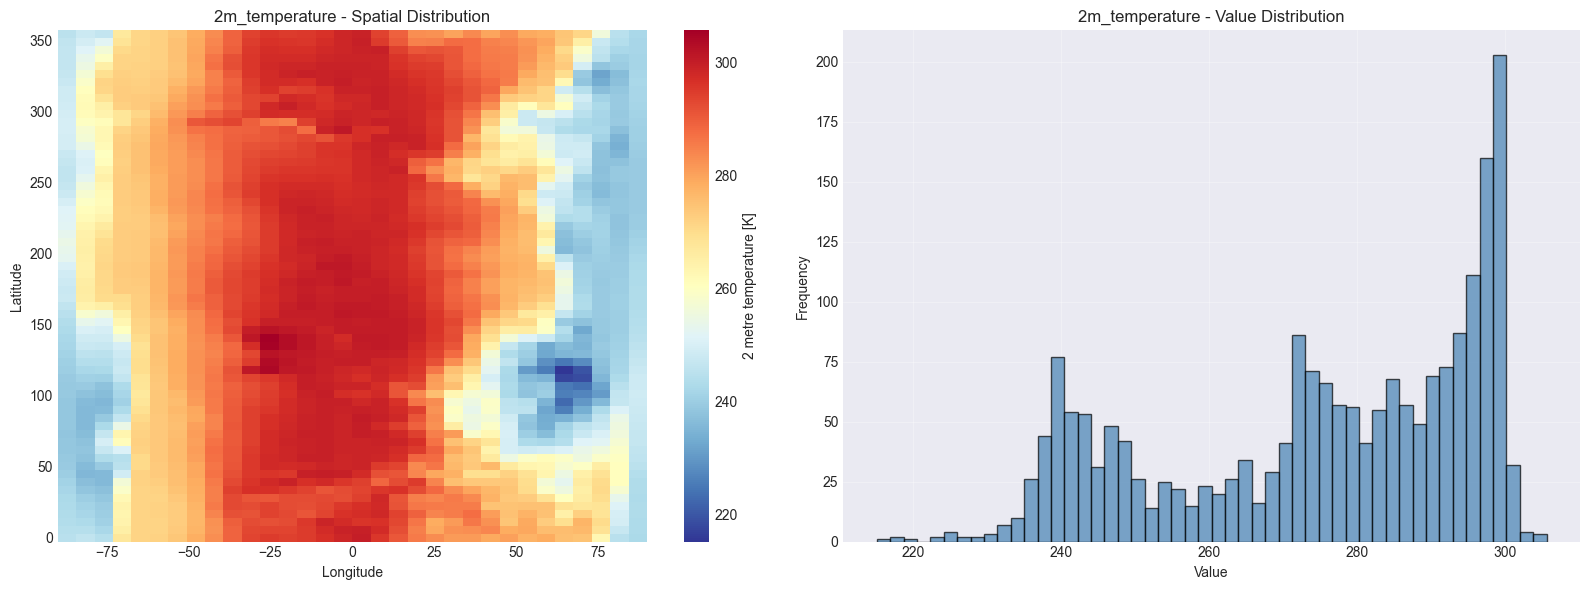

In [9]:
# 选择一个时间点
time_idx = 0
data_snapshot = data.isel(time=time_idx)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 空间分布热力图
if 'latitude' in data_snapshot.dims and 'longitude' in data_snapshot.dims:
    data_snapshot.plot(ax=axes[0], cmap='RdYlBu_r', add_colorbar=True)
    axes[0].set_title(f'{target_var} - Spatial Distribution')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')

# 数值分布直方图
values = data_snapshot.values.flatten()
values = values[~np.isnan(values)]
axes[1].hist(values, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_title(f'{target_var} - Value Distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{target_var}_spatial.png', dpi=300, bbox_inches='tight')
plt.show()


后续增加
## 6.2 全球温度分布图（气象预报风格）
## 6.3 专业地图投影版本（带海岸线）
## 6.4 多时间点对比（查看变化）
## 6.5 动画：温度场随时间演变 🎬
## 6.6 专业动画：带地图投影和海岸线 🗺️🎬


## 7. 时间序列分析


计算全球平均时间序列...


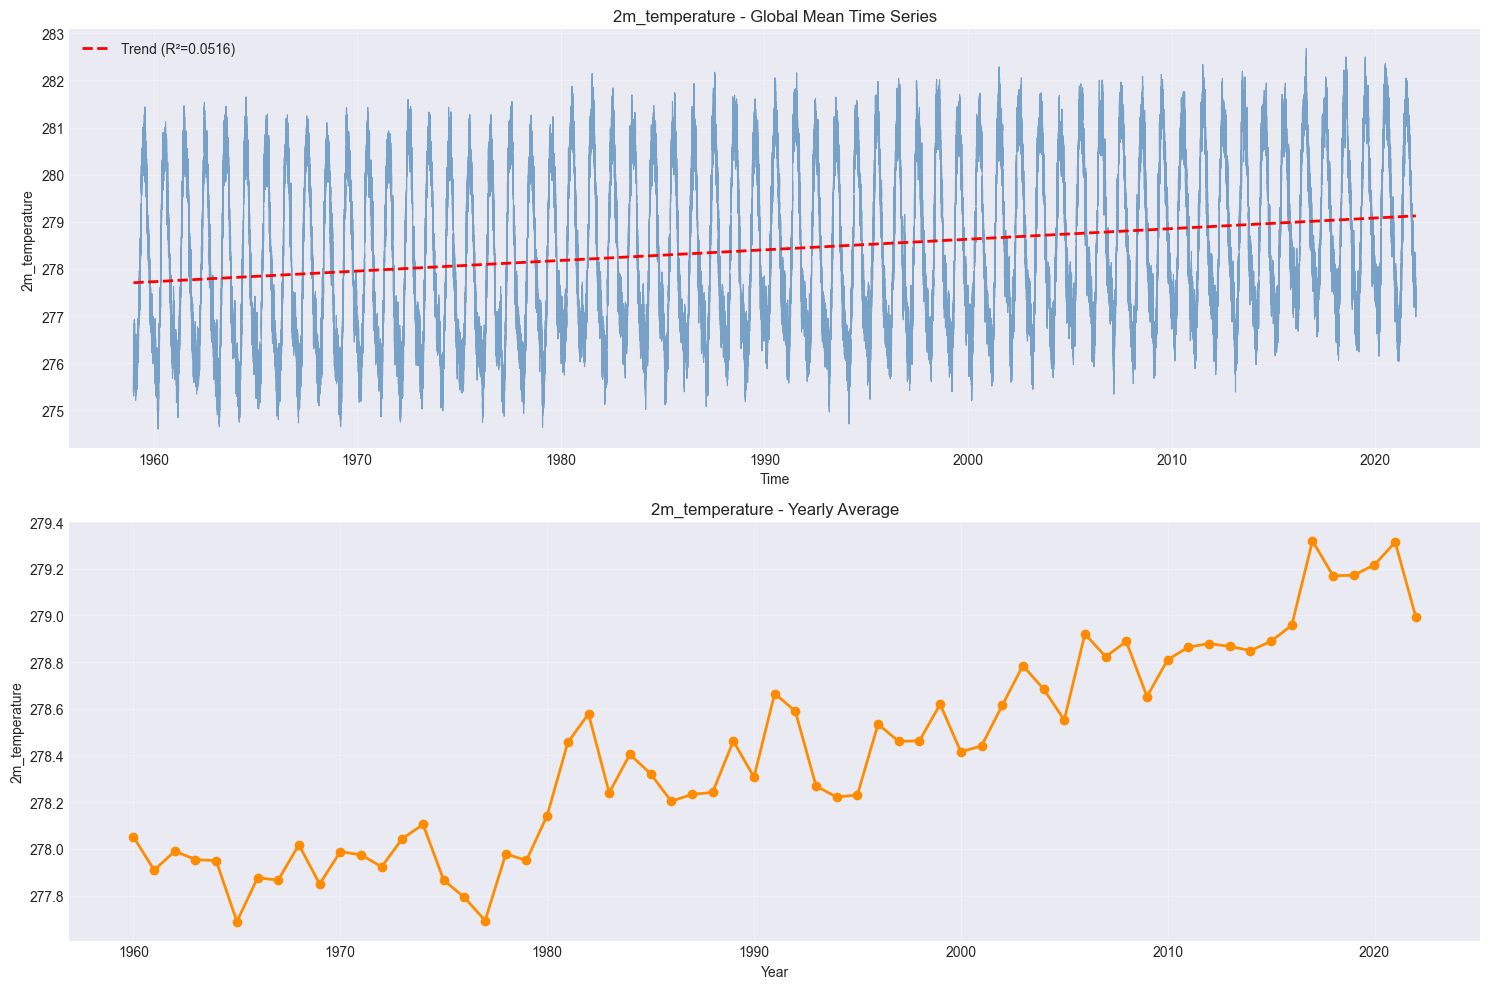


趋势分析: 斜率=1.541191e-05, R²=0.051591, p=0.000000e+00


In [10]:
# 计算全球平均时间序列
print("计算全球平均时间序列...")
data_global_mean = data.mean(dim=['latitude', 'longitude'])
time_series = data_global_mean.to_pandas()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 完整时间序列
axes[0].plot(time_series.index, time_series.values, linewidth=0.8, alpha=0.7, color='steelblue')
axes[0].set_title(f'{target_var} - Global Mean Time Series')
axes[0].set_xlabel('Time')
axes[0].set_ylabel(target_var)
axes[0].grid(True, alpha=0.3)

# 添加趋势线
x_numeric = np.arange(len(time_series))
slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, time_series.values)
trend_line = slope * x_numeric + intercept
axes[0].plot(time_series.index, trend_line, 'r--', linewidth=2, 
             label=f'Trend (R²={r_value**2:.4f})')
axes[0].legend()

# 年平均时间序列
yearly_mean = time_series.resample('Y').mean()
axes[1].plot(yearly_mean.index, yearly_mean.values, marker='o', linewidth=2, color='darkorange')
axes[1].set_title(f'{target_var} - Yearly Average')
axes[1].set_xlabel('Year')
axes[1].set_ylabel(target_var)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{target_var}_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n趋势分析: 斜率={slope:.6e}, R²={r_value**2:.6f}, p={p_value:.6e}")


## 8. 季节性分析


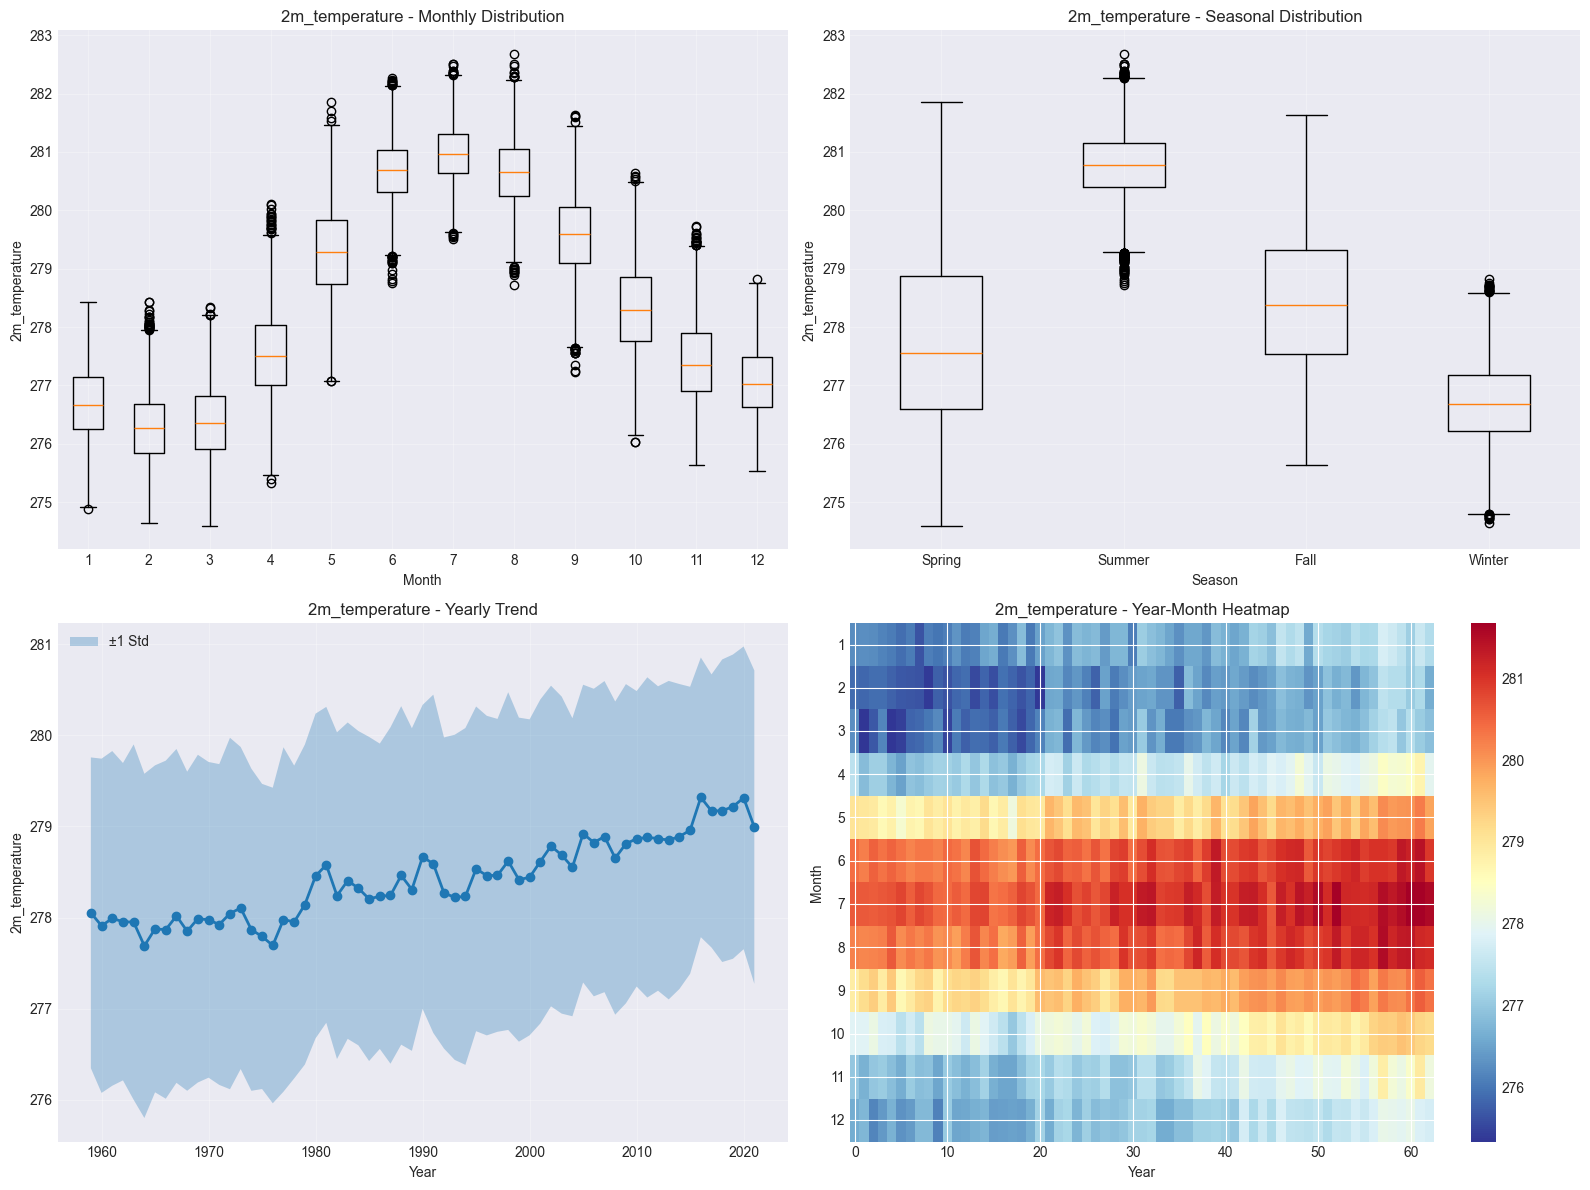

In [11]:
# 创建包含月份和年份的DataFrame
df = time_series.to_frame(name='value')
df['year'] = df.index.year
df['month'] = df.index.month
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 月度箱线图
monthly_data = [df[df['month'] == m]['value'].values for m in range(1, 13)]
axes[0, 0].boxplot(monthly_data, labels=range(1, 13))
axes[0, 0].set_title(f'{target_var} - Monthly Distribution')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel(target_var)
axes[0, 0].grid(True, alpha=0.3)

# 2. 季节箱线图
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
seasonal_data = [df[df['season'] == s]['value'].values for s in seasons]
axes[0, 1].boxplot(seasonal_data, labels=seasons)
axes[0, 1].set_title(f'{target_var} - Seasonal Distribution')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel(target_var)
axes[0, 1].grid(True, alpha=0.3)

# 3. 年度变化趋势
yearly_stats = df.groupby('year')['value'].agg(['mean', 'std'])
axes[1, 0].plot(yearly_stats.index, yearly_stats['mean'], marker='o', linewidth=2)
axes[1, 0].fill_between(yearly_stats.index, 
                         yearly_stats['mean'] - yearly_stats['std'],
                         yearly_stats['mean'] + yearly_stats['std'],
                         alpha=0.3, label='±1 Std')
axes[1, 0].set_title(f'{target_var} - Yearly Trend')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel(target_var)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. 月度-年度热力图
pivot_table = df.pivot_table(values='value', index='month', columns='year', aggfunc='mean')
im = axes[1, 1].imshow(pivot_table.values, aspect='auto', cmap='RdYlBu_r')
axes[1, 1].set_title(f'{target_var} - Year-Month Heatmap')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Month')
axes[1, 1].set_yticks(range(12))
axes[1, 1].set_yticklabels(range(1, 13))
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.savefig(f'{target_var}_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. 统计摘要


In [12]:
# 月度统计
print("月度统计摘要:")
monthly_stats = df.groupby('month')['value'].describe()
print(monthly_stats)

print("\n季节统计摘要:")
seasonal_stats = df.groupby('season')['value'].describe()
print(seasonal_stats[['mean', 'std', 'min', 'max']])


月度统计摘要:
        count        mean       std         min         25%         50%  \
month                                                                     
1      7812.0  276.697845  0.612583  274.877869  276.252502  276.671646   
2      7120.0  276.286469  0.607235  274.639862  275.848648  276.276245   
3      7812.0  276.365540  0.646315  274.601929  275.905083  276.352249   
4      7560.0  277.534119  0.765395  275.338196  277.000252  277.507935   
5      7812.0  279.284790  0.768418  277.070648  278.734573  279.287643   
6      7560.0  280.677124  0.523658  278.756897  280.314972  280.687454   
7      7812.0  280.975281  0.473503  279.513580  280.635674  280.963440   
8      7812.0  280.656342  0.568676  278.724274  280.249001  280.658569   
9      7560.0  279.560913  0.683098  277.228760  279.093628  279.596176   
10     7812.0  278.315033  0.772972  276.026855  277.758575  278.293961   
11     7560.0  277.424591  0.684402  275.643066  276.912460  277.352448   
12     7812.0  27

## 10. 导出结果

In [13]:
# 导出年度数据
yearly_data = df.groupby('year')['value'].agg(['mean', 'std', 'min', 'max'])
yearly_data.to_csv(f'{target_var}_yearly_data.csv')
print(f"✓ 年度数据已导出: {target_var}_yearly_data.csv")

# 导出月度统计
monthly_summary = df.groupby('month')['value'].agg(['mean', 'std', 'min', 'max'])
monthly_summary.to_csv(f'{target_var}_monthly_summary.csv')
print(f"✓ 月度统计已导出: {target_var}_monthly_summary.csv")

# 生成统计报告（修复版本）
report_file = f'{target_var}_report.txt'
with open(report_file, 'w', encoding='utf-8') as f:
    f.write(f"天气数据统计报告 - {target_var}\n")
    f.write(f"生成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*60 + "\n\n")
    
    # 修复: xarray对象没有describe方法，使用统计值
    f.write(f"全局统计:\n")
    f.write(f"  最小值: {float(data.min().values):.6f}\n")
    f.write(f"  最大值: {float(data.max().values):.6f}\n")
    f.write(f"  平均值: {float(data.mean().values):.6f}\n")
    f.write(f"  标准差: {float(data.std().values):.6f}\n\n")
    
    f.write(f"月度统计:\n{monthly_stats.to_string()}\n\n")
    f.write(f"季节统计:\n{seasonal_stats.to_string()}\n")
    
print(f"✓ 统计报告已保存: {report_file}")
print("\n基础分析完成！")


✓ 年度数据已导出: 2m_temperature_yearly_data.csv
✓ 月度统计已导出: 2m_temperature_monthly_summary.csv
✓ 统计报告已保存: 2m_temperature_report.txt

基础分析完成！


---
# Part 2: 地理分析和天气预测特征工程

以下是为天气预测模型准备的高级分析


## 11. 地理分析 - 区域对比

分析不同地理区域的气候特征差异


In [14]:
# 诊断：检查数据的实际坐标
print("=" * 80)
print("数据坐标诊断")
print("=" * 80)

print("\n经度坐标（前10个和后10个）:")
lon_vals = data['longitude'].values
print(f"  前10个: {lon_vals[:10]}")
print(f"  后10个: {lon_vals[-10:]}")
print(f"  总数: {len(lon_vals)}, 范围: {lon_vals.min():.2f} ~ {lon_vals.max():.2f}")

print("\n纬度坐标（前10个和后10个）:")
lat_vals = data['latitude'].values
print(f"  前10个: {lat_vals[:10]}")
print(f"  后10个: {lat_vals[-10:]}")
print(f"  总数: {len(lat_vals)}, 范围: {lat_vals.min():.2f} ~ {lat_vals.max():.2f}")
print(f"  排序: {'升序' if lat_vals[1] > lat_vals[0] else '降序'}")

print("\n数据维度:")
print(f"  data.shape: {data.shape}")
print(f"  data.dims: {data.dims}")

# 测试选择一个小区域
print("\n测试选择北美区域...")
test_lat = slice(70, 15)
test_lon = slice(190, 310)

print(f"  纬度范围: {test_lat}")
print(f"  经度范围: {test_lon}")

try:
    test_data = data.sel(latitude=test_lat, longitude=test_lon)
    print(f"  ✓ 选择成功！")
    print(f"  结果形状: {test_data.shape}")
    print(f"  结果维度: {test_data.dims}")
except Exception as e:
    print(f"  ✗ 选择失败: {e}")


数据坐标诊断

经度坐标（前10个和后10个）:
  前10个: [ 0.     5.625 11.25  16.875 22.5   28.125 33.75  39.375 45.    50.625]
  后10个: [303.75  309.375 315.    320.625 326.25  331.875 337.5   343.125 348.75
 354.375]
  总数: 64, 范围: 0.00 ~ 354.38

纬度坐标（前10个和后10个）:
  前10个: [-87.1875 -81.5625 -75.9375 -70.3125 -64.6875 -59.0625 -53.4375 -47.8125
 -42.1875 -36.5625]
  后10个: [36.5625 42.1875 47.8125 53.4375 59.0625 64.6875 70.3125 75.9375 81.5625
 87.1875]
  总数: 32, 范围: -87.19 ~ 87.19
  排序: 升序

数据维度:
  data.shape: (92044, 64, 32)
  data.dims: ('time', 'longitude', 'latitude')

测试选择北美区域...
  纬度范围: slice(70, 15, None)
  经度范围: slice(190, 310, None)
  ✓ 选择成功！
  结果形状: (92044, 22, 0)
  结果维度: ('time', 'longitude', 'latitude')


In [15]:
# 定义主要地理区域（使用布尔掩码方法）
print("=" * 80)
print("地理区域分析")
print("=" * 80)

# 获取经纬度坐标
lat_vals = data['latitude'].values
lon_vals = data['longitude'].values

print(f"\n数据网格信息:")
print(f"  经度: {len(lon_vals)} 个点, 范围 {lon_vals.min():.2f}° ~ {lon_vals.max():.2f}°")
print(f"  纬度: {len(lat_vals)} 个点, 范围 {lat_vals.min():.2f}° ~ {lat_vals.max():.2f}°")
print(f"  分辨率: 约 {360/len(lon_vals):.1f}° (经度) × {180/len(lat_vals):.1f}° (纬度)")

# 定义区域（使用0-360度系统）
def convert_lon(lon):
    """转换-180~180到0~360"""
    return lon if lon >= 0 else lon + 360

# 创建区域掩码
regions_def = {
    'North America': {
        'lat_min': 15, 'lat_max': 70,
        'lon_min': convert_lon(-170), 'lon_max': convert_lon(-50)
    },
    'Europe': {
        'lat_min': 35, 'lat_max': 70,
        'lon_min': convert_lon(-10), 'lon_max': 40
    },
    'East Asia': {
        'lat_min': 20, 'lat_max': 55,
        'lon_min': 70, 'lon_max': 145
    },
    'South Asia': {
        'lat_min': 5, 'lat_max': 35,
        'lon_min': 60, 'lon_max': 100
    },
    'Tropics': {
        'lat_min': -23.5, 'lat_max': 23.5,
        'lon_min': 0, 'lon_max': 360
    },
}

print(f"\n定义的区域（使用0-360°经度系统）:")
for name, bounds in regions_def.items():
    print(f"  {name}:")
    print(f"    纬度: {bounds['lat_min']}° ~ {bounds['lat_max']}°")
    print(f"    经度: {bounds['lon_min']}° ~ {bounds['lon_max']}°")

# 计算区域统计
region_stats = {}
print(f"\n开始计算区域统计...")

for region_name, bounds in regions_def.items():
    try:
        # 创建布尔掩码
        lat_mask = (lat_vals >= bounds['lat_min']) & (lat_vals <= bounds['lat_max'])
        
        # 处理经度（可能跨越0/360边界）
        if bounds['lon_min'] > bounds['lon_max']:  # 跨越边界
            lon_mask = (lon_vals >= bounds['lon_min']) | (lon_vals <= bounds['lon_max'])
        else:
            lon_mask = (lon_vals >= bounds['lon_min']) & (lon_vals <= bounds['lon_max'])
        
        # 选择区域数据
        region_data = data.sel(
            latitude=lat_vals[lat_mask],
            longitude=lon_vals[lon_mask]
        )
        
        n_lat = lat_mask.sum()
        n_lon = lon_mask.sum()
        
        if n_lat == 0 or n_lon == 0:
            print(f"  ✗ {region_name}: 无匹配的网格点 (lat={n_lat}, lon={n_lon})")
            continue
        
        # 计算区域平均
        region_mean = region_data.mean(dim=['latitude', 'longitude'])
        
        # 统计信息
        region_stats[region_name] = {
            'mean': float(region_mean.mean().values),
            'std': float(region_mean.std().values),
            'min': float(region_mean.min().values),
            'max': float(region_mean.max().values),
            'grid_points': f"{n_lat}×{n_lon}={n_lat*n_lon}",
            'time_steps': len(region_mean)
        }
        
        print(f"  ✓ {region_name}: {n_lat}×{n_lon} 网格点, {len(region_mean)} 时间步")
        
    except Exception as e:
        print(f"  ✗ {region_name} 失败: {type(e).__name__}: {e}")

# 显示结果
print("\n" + "=" * 80)
if region_stats:
    region_df = pd.DataFrame(region_stats).T
    print("区域统计摘要:")
    print(region_df)
    print(f"\n✓ 成功分析了 {len(region_stats)}/{len(regions_def)} 个区域")
else:
    print("⚠️  未能计算任何区域统计！")
print("=" * 80)


地理区域分析

数据网格信息:
  经度: 64 个点, 范围 0.00° ~ 354.38°
  纬度: 32 个点, 范围 -87.19° ~ 87.19°
  分辨率: 约 5.6° (经度) × 5.6° (纬度)

定义的区域（使用0-360°经度系统）:
  North America:
    纬度: 15° ~ 70°
    经度: 190° ~ 310°
  Europe:
    纬度: 35° ~ 70°
    经度: 350° ~ 40°
  East Asia:
    纬度: 20° ~ 55°
    经度: 70° ~ 145°
  South Asia:
    纬度: 5° ~ 35°
    经度: 60° ~ 100°
  Tropics:
    纬度: -23.5° ~ 23.5°
    经度: 0° ~ 360°

开始计算区域统计...
  ✓ North America: 9×22 网格点, 92044 时间步
  ✓ Europe: 6×9 网格点, 92044 时间步
  ✓ East Asia: 6×13 网格点, 92044 时间步
  ✓ South Asia: 5×7 网格点, 92044 时间步
  ✓ Tropics: 8×64 网格点, 92044 时间步

区域统计摘要:
                     mean        std         min         max grid_points  \
North America  283.277832   6.119526  269.581177  294.970245    9×22=198   
Europe         282.865814   6.719331  263.765106  298.990723      6×9=54   
East Asia      280.793304  10.295732  257.341736  299.124634     6×13=78   
South Asia     295.848083   3.817634  285.559296  303.878998      5×7=35   
Tropics        298.369507   0.652163 


生成区域时间序列对比...
  ✓ North America
  ✓ Europe
  ✓ East Asia
  ✓ South Asia
  ✓ Tropics

生成区域箱线图（最近10年）...
  ✓ North America: 16072 数据点
  ✓ Europe: 16072 数据点
  ✓ East Asia: 16072 数据点
  ✓ South Asia: 16072 数据点
  ✓ Tropics: 16072 数据点


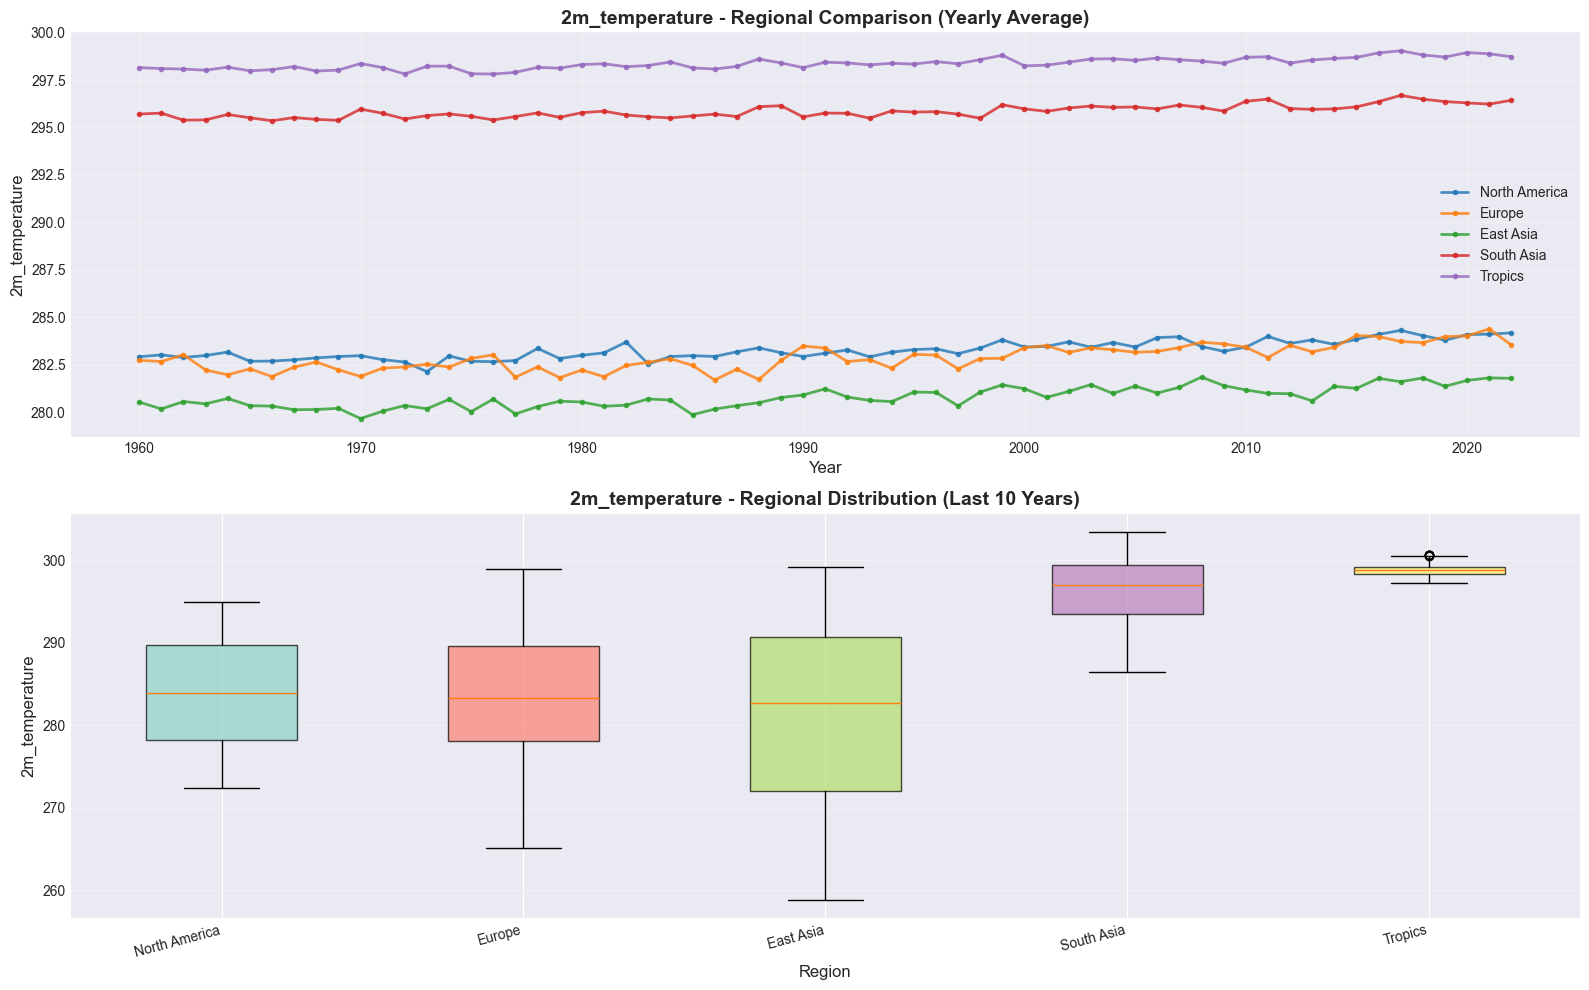


✓ 区域分析图已保存: 2m_temperature_regional_analysis.png
  成功处理 5/5 个区域


In [16]:
# 可视化区域对比
if not region_stats:
    print("⚠️  无区域统计数据，跳过可视化")
else:
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # 1. 区域年度平均值对比
    print("\n生成区域时间序列对比...")
    successful_regions = 0
    
    for region_name, bounds in regions_def.items():
        try:
            # 创建掩码
            lat_mask = (lat_vals >= bounds['lat_min']) & (lat_vals <= bounds['lat_max'])
            
            if bounds['lon_min'] > bounds['lon_max']:
                lon_mask = (lon_vals >= bounds['lon_min']) | (lon_vals <= bounds['lon_max'])
            else:
                lon_mask = (lon_vals >= bounds['lon_min']) & (lon_vals <= bounds['lon_max'])
            
            if lat_mask.sum() == 0 or lon_mask.sum() == 0:
                continue
            
            # 选择区域数据
            region_data = data.sel(
                latitude=lat_vals[lat_mask],
                longitude=lon_vals[lon_mask]
            )
            
            region_mean = region_data.mean(dim=['latitude', 'longitude'])
            yearly = region_mean.to_pandas().resample('Y').mean()
            
            axes[0].plot(yearly.index, yearly.values, marker='o', label=region_name, 
                         linewidth=2, markersize=3, alpha=0.8)
            successful_regions += 1
            print(f"  ✓ {region_name}")
            
        except Exception as e:
            print(f"  ✗ {region_name}: {e}")
            continue
    
    if successful_regions > 0:
        axes[0].set_title(f'{target_var} - Regional Comparison (Yearly Average)', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Year', fontsize=12)
        axes[0].set_ylabel(target_var, fontsize=12)
        axes[0].legend(loc='best', fontsize=10)
        axes[0].grid(True, alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, '无法生成区域对比图', ha='center', va='center', 
                     transform=axes[0].transAxes, fontsize=14, color='red')
    
    # 2. 区域箱线图对比（最近10年）
    print("\n生成区域箱线图（最近10年）...")
    recent_years = slice(str(df['year'].max()-10), str(df['year'].max()))
    region_data_list = []
    region_labels = []
    
    for region_name, bounds in regions_def.items():
        try:
            # 创建掩码
            lat_mask = (lat_vals >= bounds['lat_min']) & (lat_vals <= bounds['lat_max'])
            
            if bounds['lon_min'] > bounds['lon_max']:
                lon_mask = (lon_vals >= bounds['lon_min']) | (lon_vals <= bounds['lon_max'])
            else:
                lon_mask = (lon_vals >= bounds['lon_min']) & (lon_vals <= bounds['lon_max'])
            
            if lat_mask.sum() == 0 or lon_mask.sum() == 0:
                continue
            
            # 选择区域数据
            region_data = data.sel(
                time=recent_years,
                latitude=lat_vals[lat_mask],
                longitude=lon_vals[lon_mask]
            )
            
            region_mean = region_data.mean(dim=['latitude', 'longitude'])
            region_data_list.append(region_mean.values.flatten())
            region_labels.append(region_name)
            print(f"  ✓ {region_name}: {len(region_mean)} 数据点")
            
        except Exception as e:
            print(f"  ✗ {region_name}: {e}")
            continue
    
    if region_data_list:
        bp = axes[1].boxplot(region_data_list, labels=region_labels, patch_artist=True)
        colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        axes[1].set_title(f'{target_var} - Regional Distribution (Last 10 Years)', 
                          fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Region', fontsize=12)
        axes[1].set_ylabel(target_var, fontsize=12)
        axes[1].grid(True, alpha=0.3, axis='y')
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=15, ha='right')
    else:
        axes[1].text(0.5, 0.5, '无法生成箱线图', ha='center', va='center', 
                     transform=axes[1].transAxes, fontsize=14, color='red')
    
    plt.tight_layout()
    plt.savefig(f'{target_var}_regional_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ 区域分析图已保存: {target_var}_regional_analysis.png")
    print(f"  成功处理 {successful_regions}/{len(regions_def)} 个区域")


## 12. 空间梯度分析

计算变量的空间梯度，这对天气预测模型很重要


计算空间梯度...


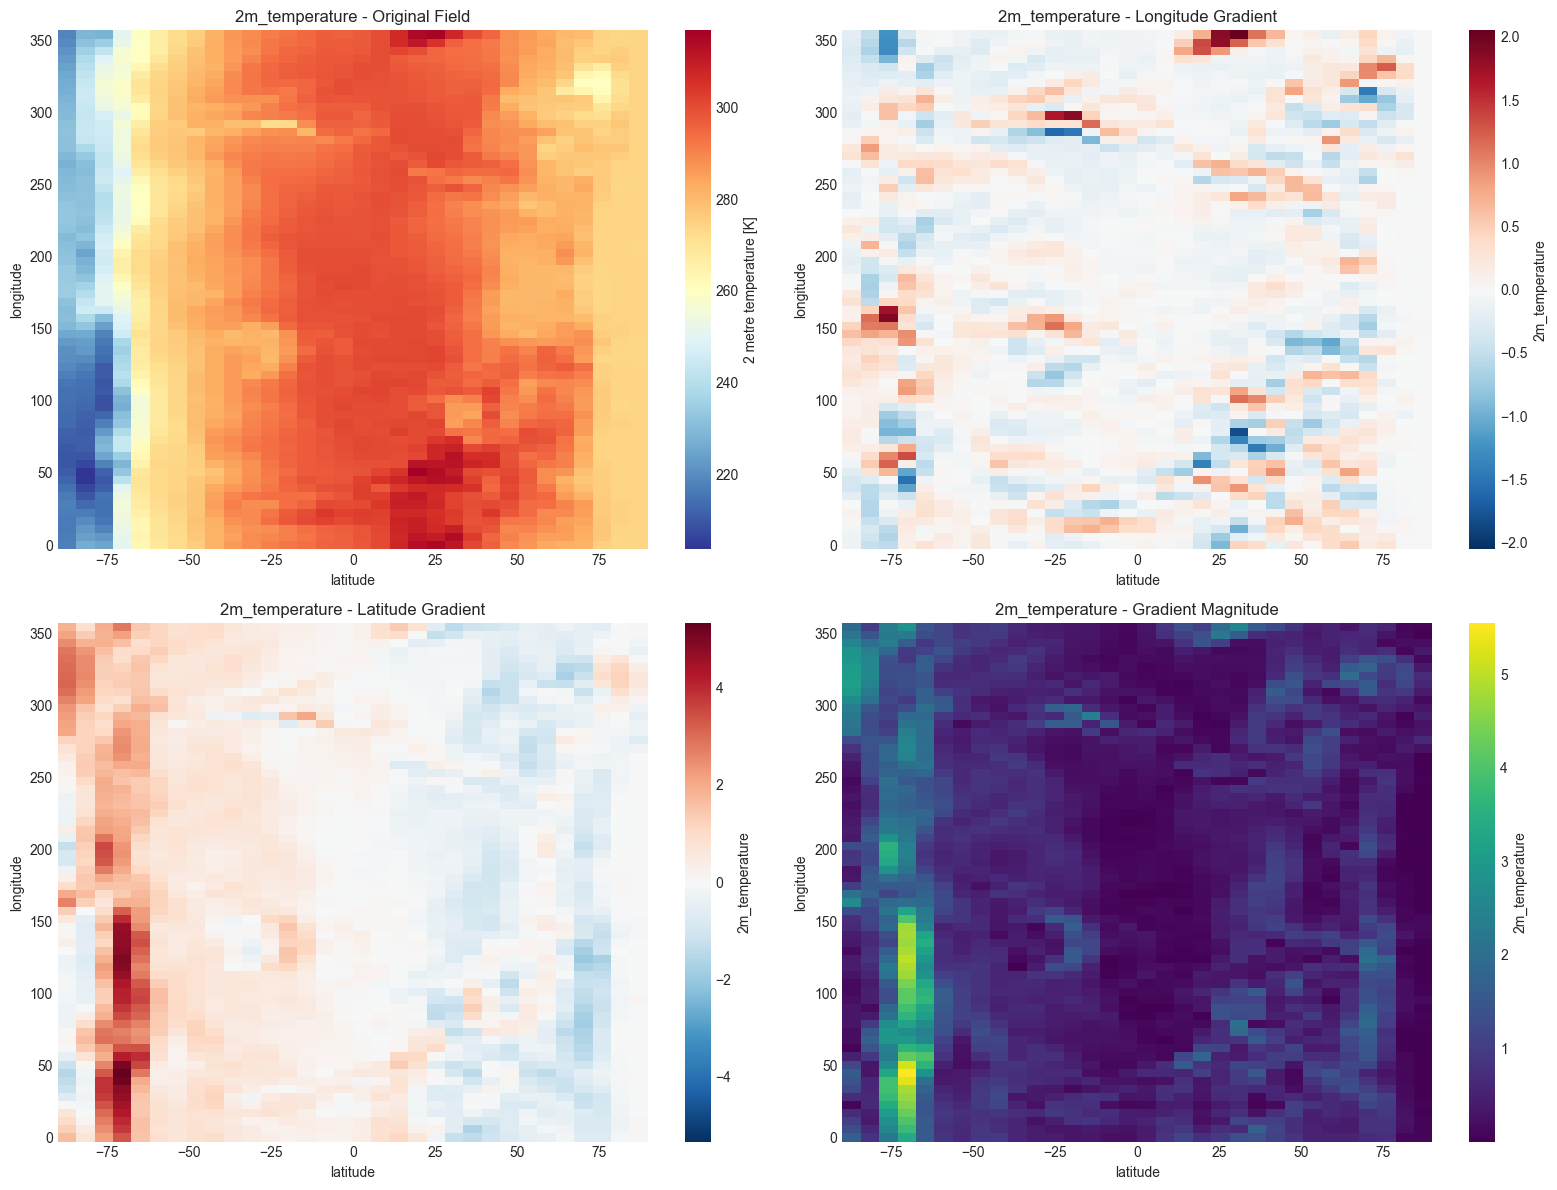

✓ 空间梯度图已保存: 2m_temperature_spatial_gradients.png

梯度统计:
  经度梯度 - 均值: 0.000341, 标准差: 0.325233
  纬度梯度 - 均值: 0.290493, 标准差: 0.959915
  梯度幅度 - 均值: 0.737555, 标准差: 0.753401


In [17]:
# 计算空间梯度（经度和纬度方向）
print("计算空间梯度...")

# 选择一个时间点
time_idx = len(data['time']) // 2  # 中间时刻
data_snapshot = data.isel(time=time_idx)

# 计算梯度
gradient_lon = data_snapshot.differentiate('longitude')
gradient_lat = data_snapshot.differentiate('latitude')

# 计算梯度幅度
gradient_magnitude = np.sqrt(gradient_lon**2 + gradient_lat**2)

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 原始数据
data_snapshot.plot(ax=axes[0, 0], cmap='RdYlBu_r', add_colorbar=True)
axes[0, 0].set_title(f'{target_var} - Original Field')

# 经度梯度
gradient_lon.plot(ax=axes[0, 1], cmap='RdBu_r', add_colorbar=True)
axes[0, 1].set_title(f'{target_var} - Longitude Gradient')

# 纬度梯度
gradient_lat.plot(ax=axes[1, 0], cmap='RdBu_r', add_colorbar=True)
axes[1, 0].set_title(f'{target_var} - Latitude Gradient')

# 梯度幅度
gradient_magnitude.plot(ax=axes[1, 1], cmap='viridis', add_colorbar=True)
axes[1, 1].set_title(f'{target_var} - Gradient Magnitude')

plt.tight_layout()
plt.savefig(f'{target_var}_spatial_gradients.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 空间梯度图已保存: {target_var}_spatial_gradients.png")
print("\n梯度统计:")
print(f"  经度梯度 - 均值: {float(gradient_lon.mean().values):.6f}, 标准差: {float(gradient_lon.std().values):.6f}")
print(f"  纬度梯度 - 均值: {float(gradient_lat.mean().values):.6f}, 标准差: {float(gradient_lat.std().values):.6f}")
print(f"  梯度幅度 - 均值: {float(gradient_magnitude.mean().values):.6f}, 标准差: {float(gradient_magnitude.std().values):.6f}")


## 13. 天气预测特征工程

为机器学习模型准备的特征分析


In [18]:
# 天气预测关键特征分析

print("="*80)
print("天气预测模型特征工程指南")
print("="*80)

# 1. 时间特征
print("\n【1. 时间特征】")
print("重要性: ⭐⭐⭐⭐⭐")
print("- 小时 (hour): 日内变化")
print("- 星期几 (day_of_week): 周期性模式")
print("- 月份 (month): 季节性变化")
print("- 季节 (season): 春夏秋冬")
print("- 年份 (year): 长期趋势")
print("- 一年中的第几天 (day_of_year): 1-365")

# 创建时间特征示例
sample_times = pd.to_datetime(data['time'].values[:100])
time_features = pd.DataFrame({
    'hour': sample_times.hour,
    'day': sample_times.day,
    'month': sample_times.month,
    'day_of_week': sample_times.dayofweek,
    'day_of_year': sample_times.dayofyear,
    'season': sample_times.month.map({12: 0, 1: 0, 2: 0,  # Winter
                                       3: 1, 4: 1, 5: 1,   # Spring
                                       6: 2, 7: 2, 8: 2,   # Summer
                                       9: 3, 10: 3, 11: 3}) # Fall
})

print("\n时间特征示例（前5行）:")
print(time_features.head())

# 2. 地理特征
print("\n【2. 地理特征】")
print("重要性: ⭐⭐⭐⭐⭐")
print("- 纬度 (latitude): 影响太阳辐射和温度")
print("- 经度 (longitude): 影响时区和大陆/海洋效应")
print("- 海拔 (elevation): 影响气压和温度（如果有数据）")
print("- 距海距离 (distance_to_ocean): 影响湿度和温度")

# 3. 气象变量（ERA5数据集中的变量）
print("\n【3. 核心气象变量】")
print("重要性: ⭐⭐⭐⭐⭐")

# 获取所有可用变量
all_variables = list(ds.data_vars)
print(f"\n当前数据集包含 {len(all_variables)} 个变量:")
for i, var in enumerate(all_variables, 1):
    print(f"  {i}. {var}")


天气预测模型特征工程指南

【1. 时间特征】
重要性: ⭐⭐⭐⭐⭐
- 小时 (hour): 日内变化
- 星期几 (day_of_week): 周期性模式
- 月份 (month): 季节性变化
- 季节 (season): 春夏秋冬
- 年份 (year): 长期趋势
- 一年中的第几天 (day_of_year): 1-365

时间特征示例（前5行）:
   hour  day  month  day_of_week  day_of_year  season
0     0    1      1            3            1       0
1     6    1      1            3            1       0
2    12    1      1            3            1       0
3    18    1      1            3            1       0
4     0    2      1            4            2       0

【2. 地理特征】
重要性: ⭐⭐⭐⭐⭐
- 纬度 (latitude): 影响太阳辐射和温度
- 经度 (longitude): 影响时区和大陆/海洋效应
- 海拔 (elevation): 影响气压和温度（如果有数据）
- 距海距离 (distance_to_ocean): 影响湿度和温度

【3. 核心气象变量】
重要性: ⭐⭐⭐⭐⭐

当前数据集包含 38 个变量:
  1. 10m_u_component_of_wind
  2. 10m_v_component_of_wind
  3. 10m_wind_speed
  4. 2m_temperature
  5. angle_of_sub_gridscale_orography
  6. anisotropy_of_sub_gridscale_orography
  7. geopotential
  8. geopotential_at_surface
  9. high_vegetation_cover
  10. lake_cover
  11. lake_depth
  12. land_sea_m

In [19]:
# 常见天气预测变量及其重要性

weather_vars = {
    "温度相关": {
        "2m_temperature": "2米温度 - 最常用的预测目标",
        "surface_temperature": "地表温度",
        "temperature": "不同气压层温度"
    },
    "风场": {
        "10m_u_component_of_wind": "10米高度U风分量（东西向）",
        "10m_v_component_of_wind": "10米高度V风分量（南北向）",
        "u_component_of_wind": "不同层U风分量",
        "v_component_of_wind": "不同层V风分量"
    },
    "湿度和降水": {
        "specific_humidity": "比湿 - 重要的湿度指标",
        "relative_humidity": "相对湿度",
        "total_precipitation": "总降水量 - 常见预测目标",
        "total_column_water_vapour": "整层水汽"
    },
    "气压": {
        "mean_sea_level_pressure": "海平面气压 - 天气系统指标",
        "surface_pressure": "地表气压",
        "geopotential": "位势高度 - 高空天气系统"
    },
    "辐射": {
        "toa_incident_solar_radiation": "大气顶入射太阳辐射",
        "surface_solar_radiation": "地表太阳辐射",
        "surface_thermal_radiation": "地表热辐射"
    }
}

print("\n【常见气象变量及用途】")
print("="*80)
for category, variables in weather_vars.items():
    print(f"\n{category}:")
    for var_name, description in variables.items():
        is_available = var_name in all_variables
        status = "✓" if is_available else "✗"
        print(f"  {status} {var_name}: {description}")

# 4. 衍生特征
print("\n\n【4. 衍生特征】")
print("重要性: ⭐⭐⭐⭐")
print("- 风速 (wind_speed): sqrt(u²+v²)")
print("- 风向 (wind_direction): atan2(v, u)")
print("- 温度梯度 (temperature_gradient): 空间导数")
print("- 气压梯度 (pressure_gradient): 空间导数")
print("- 时间变化率 (temporal_derivative): dt/dt")
print("- 日照时数 (sunshine_duration): 从辐射计算")

# 5. 统计特征
print("\n【5. 时间窗口统计特征】")
print("重要性: ⭐⭐⭐⭐")
print("对于时序预测，使用滑动窗口计算:")
print("- 过去N小时的平均值")
print("- 过去N小时的标准差")
print("- 过去N小时的最大/最小值")
print("- 过去N小时的变化率")
print("常用窗口: 6h, 12h, 24h, 48h, 72h")



【常见气象变量及用途】

温度相关:
  ✓ 2m_temperature: 2米温度 - 最常用的预测目标
  ✗ surface_temperature: 地表温度
  ✓ temperature: 不同气压层温度

风场:
  ✓ 10m_u_component_of_wind: 10米高度U风分量（东西向）
  ✓ 10m_v_component_of_wind: 10米高度V风分量（南北向）
  ✓ u_component_of_wind: 不同层U风分量
  ✓ v_component_of_wind: 不同层V风分量

湿度和降水:
  ✓ specific_humidity: 比湿 - 重要的湿度指标
  ✗ relative_humidity: 相对湿度
  ✗ total_precipitation: 总降水量 - 常见预测目标
  ✓ total_column_water_vapour: 整层水汽

气压:
  ✓ mean_sea_level_pressure: 海平面气压 - 天气系统指标
  ✓ surface_pressure: 地表气压
  ✓ geopotential: 位势高度 - 高空天气系统

辐射:
  ✓ toa_incident_solar_radiation: 大气顶入射太阳辐射
  ✗ surface_solar_radiation: 地表太阳辐射
  ✗ surface_thermal_radiation: 地表热辐射


【4. 衍生特征】
重要性: ⭐⭐⭐⭐
- 风速 (wind_speed): sqrt(u²+v²)
- 风向 (wind_direction): atan2(v, u)
- 温度梯度 (temperature_gradient): 空间导数
- 气压梯度 (pressure_gradient): 空间导数
- 时间变化率 (temporal_derivative): dt/dt
- 日照时数 (sunshine_duration): 从辐射计算

【5. 时间窗口统计特征】
重要性: ⭐⭐⭐⭐
对于时序预测，使用滑动窗口计算:
- 过去N小时的平均值
- 过去N小时的标准差
- 过去N小时的最大/最小值
- 过去N小时的变化率
常用窗口: 6h, 12h, 24h, 48h, 72h



【特征工程示例】

1. 计算风速和风向...
   风速统计: 均值=5.10 m/s, 最大=20.07 m/s


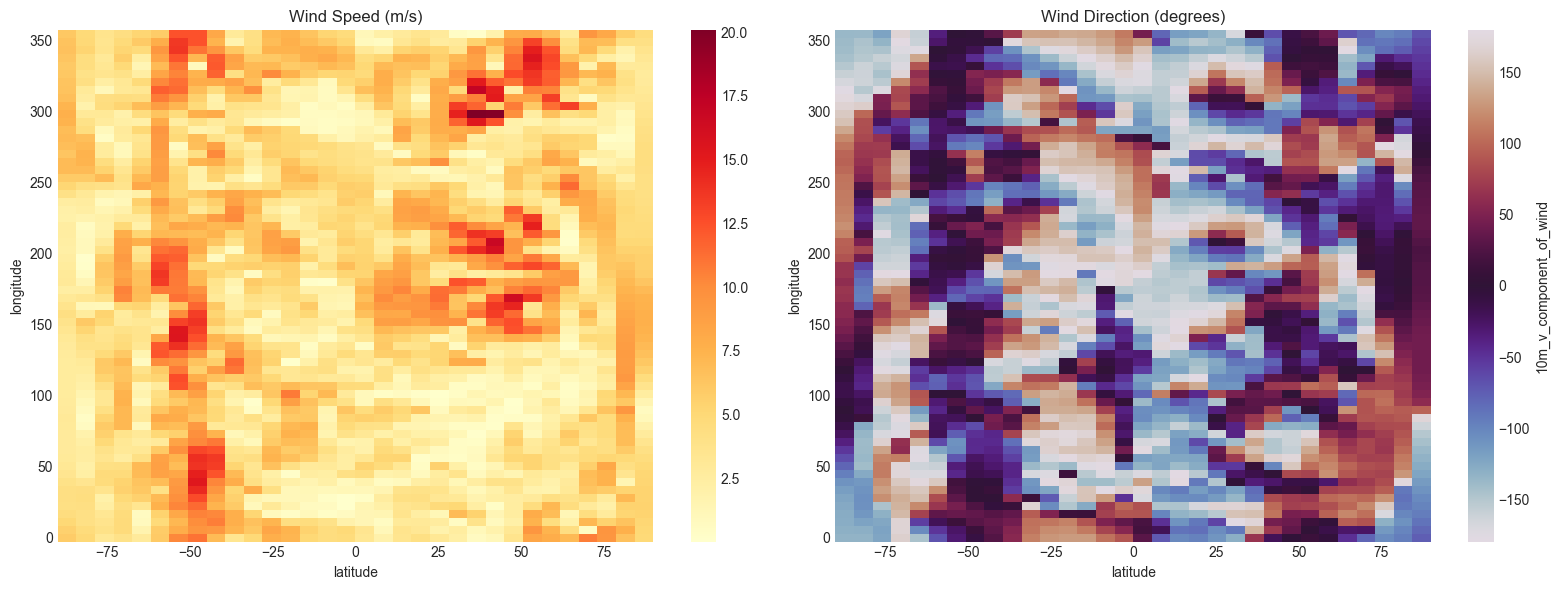

   ✓ 风场特征图已保存: wind_derived_features.png

2. 计算时间变化率...
   时间变化率统计: 均值=0.000020, 标准差=0.296253

3. 计算滑动窗口统计特征...
   生成了 12 个滑动窗口特征

   示例（最近5个时间点）:
                       mean_24h   std_24h     max_24h     min_24h    mean_48h  \
time                                                                            
2021-12-30 18:00:00  277.333069  0.226206  277.615479  277.062317  277.355877   
2021-12-31 00:00:00  277.313263  0.258917  277.615479  276.983093  277.339664   
2021-12-31 06:00:00  277.286736  0.260562  277.615479  276.983093  277.320004   
2021-12-31 12:00:00  277.256645  0.212452  277.495117  276.983093  277.301254   
2021-12-31 18:00:00  277.230927  0.209480  277.495117  276.983093  277.281998   

                      std_48h     max_48h     min_48h    mean_96h   std_96h  \
time                                                                          
2021-12-30 18:00:00  0.206926  277.645111  277.062317  277.419523  0.216780   
2021-12-31 00:00:00  0.232226  277.645111  276.9

In [20]:
# 特征工程示例：计算衍生特征

print("\n【特征工程示例】")
print("="*80)

# 示例1: 如果有U和V风分量，计算风速
if '10m_u_component_of_wind' in all_variables and '10m_v_component_of_wind' in all_variables:
    print("\n1. 计算风速和风向...")
    u_wind = ds['10m_u_component_of_wind']
    v_wind = ds['10m_v_component_of_wind']
    
    # 选择一个时间点
    time_idx = 0
    u_snapshot = u_wind.isel(time=time_idx)
    v_snapshot = v_wind.isel(time=time_idx)
    
    # 计算风速
    wind_speed = np.sqrt(u_snapshot**2 + v_snapshot**2)
    
    # 计算风向（度数）
    wind_direction = np.arctan2(v_snapshot, u_snapshot) * 180 / np.pi
    
    print(f"   风速统计: 均值={float(wind_speed.mean().values):.2f} m/s, "
          f"最大={float(wind_speed.max().values):.2f} m/s")
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    wind_speed.plot(ax=axes[0], cmap='YlOrRd', add_colorbar=True)
    axes[0].set_title('Wind Speed (m/s)')
    
    wind_direction.plot(ax=axes[1], cmap='twilight', add_colorbar=True)
    axes[1].set_title('Wind Direction (degrees)')
    
    plt.tight_layout()
    plt.savefig('wind_derived_features.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ 风场特征图已保存: wind_derived_features.png")

# 示例2: 计算时间变化率
print("\n2. 计算时间变化率...")
# 选择全球平均值
global_mean = data.mean(dim=['latitude', 'longitude'])

# 计算时间导数（简单差分）
temporal_derivative = global_mean.diff(dim='time')

print(f"   时间变化率统计: 均值={float(temporal_derivative.mean().values):.6f}, "
      f"标准差={float(temporal_derivative.std().values):.6f}")

# 示例3: 滑动窗口特征
print("\n3. 计算滑动窗口统计特征...")
window_sizes = [4, 8, 16]  # 对应6h数据的24h, 48h, 96h窗口

ts_series = global_mean.to_pandas()
window_features = pd.DataFrame(index=ts_series.index)

for window in window_sizes:
    hours = window * 6  # 6小时间隔
    window_features[f'mean_{hours}h'] = ts_series.rolling(window=window, min_periods=1).mean()
    window_features[f'std_{hours}h'] = ts_series.rolling(window=window, min_periods=1).std()
    window_features[f'max_{hours}h'] = ts_series.rolling(window=window, min_periods=1).max()
    window_features[f'min_{hours}h'] = ts_series.rolling(window=window, min_periods=1).min()

print(f"   生成了 {len(window_features.columns)} 个滑动窗口特征")
print("\n   示例（最近5个时间点）:")
print(window_features.tail())


## 14. 天气预测模型架构建议


In [21]:
print("="*80)
print("天气预测模型架构建议")
print("="*80)

model_architectures = {
    "1. 传统机器学习模型": {
        "适用场景": "单点预测、短期预测（<24小时）",
        "输入特征": [
            "历史气象数据（过去24-72小时）",
            "时间特征（小时、星期、月份等）",
            "地理特征（经纬度）",
            "统计特征（均值、标准差、最值等）"
        ],
        "输出": "未来6/12/24小时的气象变量",
        "模型选择": [
            "Random Forest",
            "XGBoost",
            "LightGBM",
            "Support Vector Regression"
        ]
    },
    "2. 循环神经网络 (RNN/LSTM/GRU)": {
        "适用场景": "时间序列预测、单点或区域预测",
        "输入特征": [
            "序列输入: (时间步, 特征数)",
            "例如: 过去72小时的数据，每6小时一个时间步",
            "特征: 温度、气压、风速、湿度等"
        ],
        "输出": "未来N个时间步的预测值",
        "模型选择": [
            "LSTM (适合长序列)",
            "GRU (计算效率更高)",
            "Bidirectional LSTM",
            "Encoder-Decoder架构"
        ]
    },
    "3. 卷积神经网络 (CNN)": {
        "适用场景": "空间模式识别、图像式天气数据",
        "输入特征": [
            "2D/3D网格数据: (lat, lon, features)",
            "例如: 64x32的全球网格",
            "多通道: 温度、气压、风场等"
        ],
        "输出": "同样大小的空间网格预测",
        "模型选择": [
            "U-Net (适合保持空间分辨率)",
            "ResNet",
            "ConvLSTM (结合时空特征)"
        ]
    },
    "4. Transformer模型": {
        "适用场景": "长期预测、全球预测",
        "输入特征": [
            "Sequence of tokens (可以是时间点或空间点)",
            "Multi-head attention捕捉全局依赖",
            "Positional encoding表示时空位置"
        ],
        "输出": "未来多个时间步的全球预测",
        "模型选择": [
            "Pangu-Weather",
            "FourCastNet",
            "GraphCast",
            "ClimaX"
        ]
    },
    "5. 物理引导的神经网络": {
        "适用场景": "需要物理约束的预测",
        "输入特征": [
            "气象变量",
            "物理方程作为约束",
            "能量守恒、质量守恒等"
        ],
        "输出": "物理上合理的预测",
        "模型选择": [
            "Physics-Informed Neural Networks (PINNs)",
            "Neural ODEs",
            "Hybrid models (ML + 数值天气预报)"
        ]
    }
}

for model_type, details in model_architectures.items():
    print(f"\n{model_type}")
    print("-" * 80)
    print(f"适用场景: {details['适用场景']}")
    print(f"\n输入特征:")
    for feature in details['输入特征']:
        print(f"  • {feature}")
    print(f"\n输出: {details['输出']}")
    print(f"\n推荐模型:")
    for model in details['模型选择']:
        print(f"  ✓ {model}")


天气预测模型架构建议

1. 传统机器学习模型
--------------------------------------------------------------------------------
适用场景: 单点预测、短期预测（<24小时）

输入特征:
  • 历史气象数据（过去24-72小时）
  • 时间特征（小时、星期、月份等）
  • 地理特征（经纬度）
  • 统计特征（均值、标准差、最值等）

输出: 未来6/12/24小时的气象变量

推荐模型:
  ✓ Random Forest
  ✓ XGBoost
  ✓ LightGBM
  ✓ Support Vector Regression

2. 循环神经网络 (RNN/LSTM/GRU)
--------------------------------------------------------------------------------
适用场景: 时间序列预测、单点或区域预测

输入特征:
  • 序列输入: (时间步, 特征数)
  • 例如: 过去72小时的数据，每6小时一个时间步
  • 特征: 温度、气压、风速、湿度等

输出: 未来N个时间步的预测值

推荐模型:
  ✓ LSTM (适合长序列)
  ✓ GRU (计算效率更高)
  ✓ Bidirectional LSTM
  ✓ Encoder-Decoder架构

3. 卷积神经网络 (CNN)
--------------------------------------------------------------------------------
适用场景: 空间模式识别、图像式天气数据

输入特征:
  • 2D/3D网格数据: (lat, lon, features)
  • 例如: 64x32的全球网格
  • 多通道: 温度、气压、风场等

输出: 同样大小的空间网格预测

推荐模型:
  ✓ U-Net (适合保持空间分辨率)
  ✓ ResNet
  ✓ ConvLSTM (结合时空特征)

4. Transformer模型
--------------------------------------------------------------------------------


In [22]:
# 典型的输入输出格式

print("\n" + "="*80)
print("典型的模型输入输出格式")
print("="*80)

print("\n【方案1: 单点时间序列预测】")
print("-" * 80)
print("输入形状: (batch_size, sequence_length, n_features)")
print("  - batch_size: 批次大小，如32")
print("  - sequence_length: 历史时间步数，如12（过去72小时，每6小时一步）")
print("  - n_features: 特征数，如10（温度、气压、风速U、风速V、湿度等）")
print("\n输出形状: (batch_size, forecast_length, n_targets)")
print("  - forecast_length: 预测时间步数，如4（未来24小时）")
print("  - n_targets: 预测目标数，如1（只预测温度）")
print("\n示例: (32, 12, 10) -> (32, 4, 1)")

print("\n【方案2: 空间网格预测】")
print("-" * 80)
print("输入形状: (batch_size, time_steps, lat, lon, channels)")
print("  - batch_size: 批次大小，如16")
print("  - time_steps: 历史时间步数，如4")
print("  - lat: 纬度网格数，如64")
print("  - lon: 经度网格数，如32")
print("  - channels: 特征通道数，如5（多个气象变量）")
print("\n输出形状: (batch_size, forecast_steps, lat, lon, channels)")
print("  - forecast_steps: 预测时间步数，如1")
print("\n示例: (16, 4, 64, 32, 5) -> (16, 1, 64, 32, 5)")

print("\n【方案3: 全球预测（Transformer风格）】")
print("-" * 80)
print("输入形状: (batch_size, n_patches, time_steps, features)")
print("  - n_patches: 空间块数，如64x32=2048")
print("  - time_steps: 时间步数，如8")
print("  - features: 每个patch的特征数，如10")
print("\n输出形状: (batch_size, n_patches, forecast_steps, features)")
print("\n示例: (8, 2048, 8, 10) -> (8, 2048, 4, 10)")

# 数据准备建议
print("\n" + "="*80)
print("数据准备流程")
print("="*80)
print("""
1. 数据加载和清洗
   - 加载ERA5数据（zarr/netCDF格式）
   - 处理缺失值（插值或删除）
   - 检查数据一致性

2. 特征工程
   - 提取时间特征（hour, day, month, etc.）
   - 计算衍生特征（风速、梯度等）
   - 标准化/归一化（很重要！）

3. 创建训练样本
   - 滑动窗口生成样本对
   - 输入: t-n到t的历史数据
   - 输出: t+1到t+m的未来数据

4. 数据划分
   - 训练集: 70-80%（通常按时间顺序）
   - 验证集: 10-15%
   - 测试集: 10-15%
   注意: 时间序列不能随机划分！

5. 数据加载器
   - 使用DataLoader批量加载
   - 考虑使用数据增强（空间翻转等）
   - 内存映射处理大数据
""")



典型的模型输入输出格式

【方案1: 单点时间序列预测】
--------------------------------------------------------------------------------
输入形状: (batch_size, sequence_length, n_features)
  - batch_size: 批次大小，如32
  - sequence_length: 历史时间步数，如12（过去72小时，每6小时一步）
  - n_features: 特征数，如10（温度、气压、风速U、风速V、湿度等）

输出形状: (batch_size, forecast_length, n_targets)
  - forecast_length: 预测时间步数，如4（未来24小时）
  - n_targets: 预测目标数，如1（只预测温度）

示例: (32, 12, 10) -> (32, 4, 1)

【方案2: 空间网格预测】
--------------------------------------------------------------------------------
输入形状: (batch_size, time_steps, lat, lon, channels)
  - batch_size: 批次大小，如16
  - time_steps: 历史时间步数，如4
  - lat: 纬度网格数，如64
  - lon: 经度网格数，如32
  - channels: 特征通道数，如5（多个气象变量）

输出形状: (batch_size, forecast_steps, lat, lon, channels)
  - forecast_steps: 预测时间步数，如1

示例: (16, 4, 64, 32, 5) -> (16, 1, 64, 32, 5)

【方案3: 全球预测（Transformer风格）】
--------------------------------------------------------------------------------
输入形状: (batch_size, n_patches, time_steps, features)
  - n_patches: 空

实际数据准备示例

创建的训练样本:
  输入形状 (X): (92028, 12)
  输出形状 (y): (92028, 4)
  总样本数: 92028

数据集划分:
  训练集: 64419 样本 (70.0%)
  验证集: 13804 样本 (15.0%)
  测试集: 13805 样本 (15.0%)


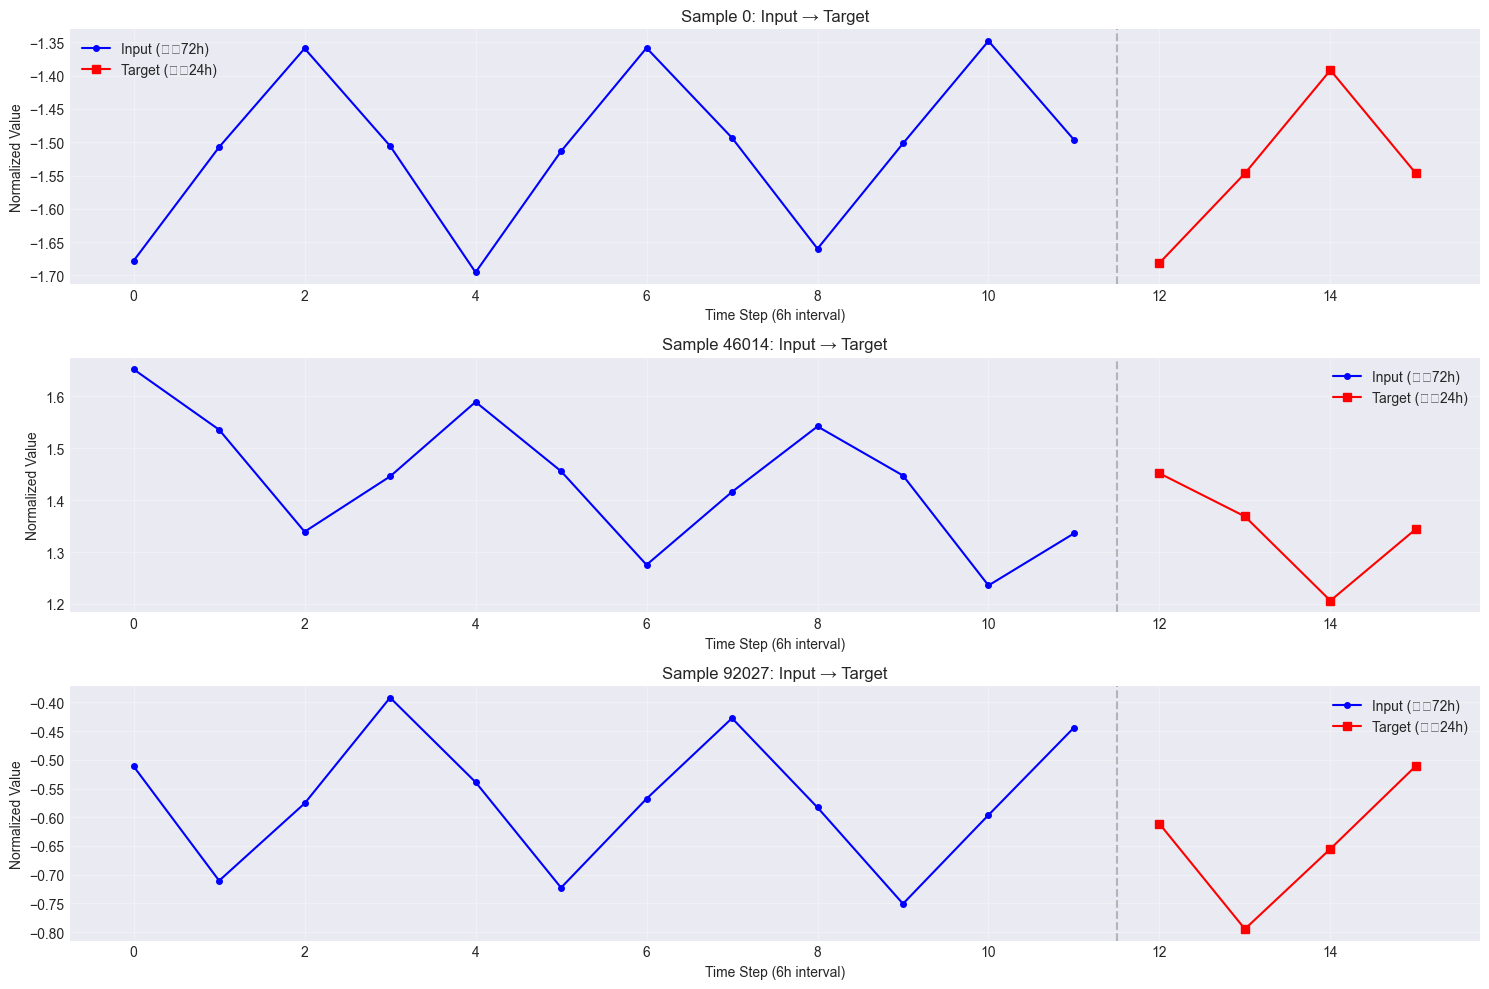


✓ 训练样本示例图已保存: training_samples_example.png


In [23]:
# 实际数据准备示例

print("="*80)
print("实际数据准备示例")
print("="*80)

# 示例: 创建用于LSTM的训练样本
def create_sequences(data, seq_length=12, forecast_length=4):
    """
    创建时间序列训练样本
    
    Args:
        data: 1D时间序列数据
        seq_length: 输入序列长度（历史窗口）
        forecast_length: 预测长度
    
    Returns:
        X: 输入序列 (n_samples, seq_length, 1)
        y: 目标序列 (n_samples, forecast_length, 1)
    """
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+forecast_length])
    return np.array(X), np.array(y)

# 使用全球平均时间序列作为示例
ts_data = time_series.values

# 标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ts_normalized = scaler.fit_transform(ts_data.reshape(-1, 1)).flatten()

# 创建序列
seq_length = 12  # 72小时历史（6小时间隔）
forecast_length = 4  # 24小时预测

X, y = create_sequences(ts_normalized, seq_length, forecast_length)

print(f"\n创建的训练样本:")
print(f"  输入形状 (X): {X.shape}")
print(f"  输出形状 (y): {y.shape}")
print(f"  总样本数: {len(X)}")

# 划分训练/验证/测试集
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"\n数据集划分:")
print(f"  训练集: {X_train.shape[0]} 样本 ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  验证集: {X_val.shape[0]} 样本 ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  测试集: {X_test.shape[0]} 样本 ({X_test.shape[0]/len(X)*100:.1f}%)")

# 可视化样本示例
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, idx in enumerate([0, len(X)//2, len(X)-1]):
    ax = axes[i]
    
    # 绘制输入序列
    ax.plot(range(seq_length), X[idx], 'b-o', label='Input (历史72h)', markersize=4)
    
    # 绘制目标序列
    ax.plot(range(seq_length, seq_length+forecast_length), y[idx], 'r-s', 
            label='Target (未来24h)', markersize=6)
    
    ax.axvline(x=seq_length-0.5, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Time Step (6h interval)')
    ax.set_ylabel('Normalized Value')
    ax.set_title(f'Sample {idx}: Input → Target')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_samples_example.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 训练样本示例图已保存: training_samples_example.png")


## 15. 模型评估指标


In [24]:
print("="*80)
print("天气预测模型评估指标")
print("="*80)

evaluation_metrics = {
    "回归指标（连续值预测）": {
        "MAE (Mean Absolute Error)": {
            "描述": "平均绝对误差，与原始单位相同",
            "公式": "mean(|y_pred - y_true|)",
            "优点": "易于理解，对异常值不敏感",
            "Python": "from sklearn.metrics import mean_absolute_error"
        },
        "RMSE (Root Mean Squared Error)": {
            "描述": "均方根误差，惩罚大误差",
            "公式": "sqrt(mean((y_pred - y_true)²))",
            "优点": "标准指标，对大误差敏感",
            "Python": "from sklearn.metrics import mean_squared_error; rmse = sqrt(mse)"
        },
        "R² Score": {
            "描述": "决定系数，解释方差比例",
            "公式": "1 - SS_res / SS_tot",
            "范围": "(-∞, 1]，1表示完美拟合",
            "Python": "from sklearn.metrics import r2_score"
        },
        "MAPE (Mean Absolute Percentage Error)": {
            "描述": "平均绝对百分比误差",
            "公式": "mean(|y_pred - y_true| / |y_true|) × 100%",
            "优点": "尺度无关，易于比较",
            "注意": "当y_true接近0时不适用"
        }
    },
    "空间评估指标": {
        "Spatial RMSE": {
            "描述": "每个网格点的RMSE",
            "用途": "识别预测困难的区域"
        },
        "Pattern Correlation": {
            "描述": "空间模式相关性",
            "用途": "评估空间结构的准确性"
        },
        "ACC (Anomaly Correlation Coefficient)": {
            "描述": "异常场相关系数",
            "用途": "天气预报标准指标"
        }
    },
    "概率预测指标": {
        "Brier Score": {
            "描述": "概率预测准确度",
            "用途": "评估概率预报"
        },
        "CRPS (Continuous Ranked Probability Score)": {
            "描述": "连续型概率分数",
            "用途": "集合预报评估"
        }
    },
    "分类指标（天气现象预测）": {
        "Accuracy": "整体准确率",
        "Precision": "精确率",
        "Recall": "召回率",
        "F1-Score": "F1分数",
        "CSI (Critical Success Index)": "关键成功指数，降水预报常用"
    }
}

for category, metrics in evaluation_metrics.items():
    print(f"\n【{category}】")
    print("-" * 80)
    if isinstance(metrics, dict):
        for metric_name, details in metrics.items():
            print(f"\n{metric_name}:")
            if isinstance(details, dict):
                for key, value in details.items():
                    print(f"  {key}: {value}")
            else:
                print(f"  {details}")

# 实际评估示例
print("\n\n" + "="*80)
print("评估指标计算示例")
print("="*80)

# 使用之前创建的测试集
# 这里用持久性预测作为baseline
print(X_test.shape, y_test.shape)
# (13805, 12) (13805, 4)

# y_test_flat = y_test[:, 0, 0]  # 第一个预测步
# y_baseline = X_test[:, -1, 0]  # 持久性预测（最后一个输入值）


y_test_flat = y_test[:, 0]  # 第一个预测步
y_baseline = X_test[:, 0]  # 持久性预测（最后一个输入值）



# 计算评估指标
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_flat, y_baseline)
rmse = np.sqrt(mean_squared_error(y_test_flat, y_baseline))
r2 = r2_score(y_test_flat, y_baseline)

print(f"\nBaseline模型性能（持久性预测）:")
print(f"  MAE: {mae:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  R² Score: {r2:.6f}")

print(f"\n注意: 这些值是标准化后的，实际使用时需要反标准化")
print(f"你的模型应该显著优于这个baseline！")


天气预测模型评估指标

【回归指标（连续值预测）】
--------------------------------------------------------------------------------

MAE (Mean Absolute Error):
  描述: 平均绝对误差，与原始单位相同
  公式: mean(|y_pred - y_true|)
  优点: 易于理解，对异常值不敏感
  Python: from sklearn.metrics import mean_absolute_error

RMSE (Root Mean Squared Error):
  描述: 均方根误差，惩罚大误差
  公式: sqrt(mean((y_pred - y_true)²))
  优点: 标准指标，对大误差敏感
  Python: from sklearn.metrics import mean_squared_error; rmse = sqrt(mse)

R² Score:
  描述: 决定系数，解释方差比例
  公式: 1 - SS_res / SS_tot
  范围: (-∞, 1]，1表示完美拟合
  Python: from sklearn.metrics import r2_score

MAPE (Mean Absolute Percentage Error):
  描述: 平均绝对百分比误差
  公式: mean(|y_pred - y_true| / |y_true|) × 100%
  优点: 尺度无关，易于比较
  注意: 当y_true接近0时不适用

【空间评估指标】
--------------------------------------------------------------------------------

Spatial RMSE:
  描述: 每个网格点的RMSE
  用途: 识别预测困难的区域

Pattern Correlation:
  描述: 空间模式相关性
  用途: 评估空间结构的准确性

ACC (Anomaly Correlation Coefficient):
  描述: 异常场相关系数
  用途: 天气预报标准指标

【概率预测指标】
--------------------

## 16. 总结和下一步


In [25]:
print("="*80)
print("分析总结")
print("="*80)

print(f"""
本notebook已完成以下分析：

✓ 基础数据分析
  - 数据加载和基本信息查看
  - 统计分析（均值、标准差、分位数等）
  - 缺失值检查

✓ 可视化分析
  - 空间分布图
  - 时间序列（含趋势分析）
  - 季节性分析
  - 区域对比

✓ 地理分析
  - 7个主要地理区域的对比
  - 空间梯度计算
  - 区域箱线图

✓ 天气预测特征工程
  - 时间特征（小时、月份、季节等）
  - 衍生特征（风速、风向、梯度等）
  - 滑动窗口统计特征
  - 训练样本生成示例

✓ 模型架构建议
  - 5种不同的模型类型
  - 输入输出格式说明
  - 数据准备流程

✓ 评估指标
  - 回归指标（MAE, RMSE, R²）
  - 空间评估指标
  - Baseline模型对比

""")

print("="*80)
print("下一步建议")
print("="*80)

next_steps = """
1. 数据准备
   □ 下载完整ERA5数据集（或使用子集）
   □ 确定预测目标（温度、降水、风速等）
   □ 选择预测时间范围（6h, 12h, 24h等）
   □ 处理缺失值和异常值

2. 特征工程
   □ 提取所有需要的气象变量
   □ 计算衍生特征（风速、梯度等）
   □ 创建时间特征
   □ 标准化/归一化数据

3. 模型开发
   □ 选择模型架构（LSTM, CNN, Transformer等）
   □ 实现数据加载器
   □ 构建模型
   □ 定义损失函数和优化器

4. 训练和验证
   □ 训练模型
   □ 监控训练/验证损失
   □ 调整超参数
   □ 防止过拟合（dropout, early stopping等）

5. 评估和部署
   □ 在测试集上评估
   □ 可视化预测结果
   □ 与baseline和其他模型对比
   □ 部署模型（如果需要）

6. 推荐阅读
   □ WeatherBench 2.0论文
   □ Pangu-Weather论文
   □ FourCastNet论文
   □ ERA5数据文档
"""

print(next_steps)

print("="*80)
print("所有分析完成！祝您的天气预测模型开发顺利！")
print("="*80)


分析总结

本notebook已完成以下分析：

✓ 基础数据分析
  - 数据加载和基本信息查看
  - 统计分析（均值、标准差、分位数等）
  - 缺失值检查

✓ 可视化分析
  - 空间分布图
  - 时间序列（含趋势分析）
  - 季节性分析
  - 区域对比

✓ 地理分析
  - 7个主要地理区域的对比
  - 空间梯度计算
  - 区域箱线图

✓ 天气预测特征工程
  - 时间特征（小时、月份、季节等）
  - 衍生特征（风速、风向、梯度等）
  - 滑动窗口统计特征
  - 训练样本生成示例

✓ 模型架构建议
  - 5种不同的模型类型
  - 输入输出格式说明
  - 数据准备流程

✓ 评估指标
  - 回归指标（MAE, RMSE, R²）
  - 空间评估指标
  - Baseline模型对比


下一步建议

1. 数据准备
   □ 下载完整ERA5数据集（或使用子集）
   □ 确定预测目标（温度、降水、风速等）
   □ 选择预测时间范围（6h, 12h, 24h等）
   □ 处理缺失值和异常值

2. 特征工程
   □ 提取所有需要的气象变量
   □ 计算衍生特征（风速、梯度等）
   □ 创建时间特征
   □ 标准化/归一化数据

3. 模型开发
   □ 选择模型架构（LSTM, CNN, Transformer等）
   □ 实现数据加载器
   □ 构建模型
   □ 定义损失函数和优化器

4. 训练和验证
   □ 训练模型
   □ 监控训练/验证损失
   □ 调整超参数
   □ 防止过拟合（dropout, early stopping等）

5. 评估和部署
   □ 在测试集上评估
   □ 可视化预测结果
   □ 与baseline和其他模型对比
   □ 部署模型（如果需要）

6. 推荐阅读
   □ WeatherBench 2.0论文
   □ Pangu-Weather论文
   □ FourCastNet论文
   □ ERA5数据文档

所有分析完成！祝您的天气预测模型开发顺利！
